## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
## <center> TP4  - Annotation de questions avec Wikidata <br>  Automne 2023 </center>

## 1. DESCRIPTION

Dans le cadre de ce projet, vous effectuerez une annotation de questions en langue naturelle en utilisant différents modèles avec pour objectif ultime de proposer une méthode qui dépasse les performances des équipes concurrentes.

Par exemple, étant donnée la question:
What is the country for head of state of Justin Trudeau ?
Votre modèle devra retourner :
what is the <\<wd:Q6256\>> for <\<wdt:P35\>> of <\<wd:Q3099714\>> ?

Les éléments ayant pour préfixe wd sont des URIs de Wikidata. Par exemple wd:Q6256 correspond à l'URI https://www.wikidata.org/wiki/Q6256

Wikidata est une base de données collaborative et structurée qui fait partie du projet Wikimedia, tout comme Wikipédia. Contrairement à Wikipédia, qui se concentre sur la création et la gestion de contenu encyclopédique, Wikidata se spécialise dans la collecte et la gestion de données structurées.

**Ressources Wikidata :**

Les ressources sont des entités du monde réel avec un identifiant unique précédé du préfixe "wd".

Voici quelques exemples d'éléments :

1. **La Tour Eiffel (Identifiant : Q243)** - Il s'agit d'un élément représentant la célèbre tour située à Paris.

2. **Albert Einstein (Identifiant : Q937)** - C'est un élément qui représente le physicien renommé.

3. **Mona Lisa (La Joconde) (Identifiant : Q12418)** - Un élément correspondant à l'œuvre d'art iconique de Leonardo da Vinci.

**Propriétés Wikidata :**

Les propriétés sont des caractéristiques ou des informations spécifiques associées aux éléments. Chaque propriété a un identifiant unique avec l'un des préfixes suivant: "wdt", "ps" ou "pq" et est utilisée pour décrire, quantifier ou qualifier les éléments. Voici des exemples de propriétés avec les éléments correspondants :

1. **Hauteur (Propriété : P2049)** - Une propriété utilisée pour indiquer la hauteur d'une structure. Par exemple, la hauteur de la Tour Eiffel est stockée dans cette propriété.

2. **Date de naissance (Propriété : P569)** - Une propriété pour enregistrer la date de naissance des individus. Par exemple, la date de naissance d'Albert Einstein est stockée grâce à cette propriété.

3. **Créateur (Propriété : P170)** - Cette propriété est utilisée pour spécifier qui a créé une œuvre d'art. Dans le cas de la Mona Lisa, on associe cette propriété à l'élément correspondant pour indiquer que Leonardo da Vinci en est le créateur.


Le jeu de données utilisé comprend des questions rédigées en langage naturel, ainsi que ces mêmes questions annotées avec des identifiants provenant de la base de connaissances Wikidata.

Pour illustrer ce jeu de données, voici un exemple :

| question_id |        question_raw        |                 question_original                 |              question_tagged               |
| :---------: | :------------------------: | :---------------------------------------------: | :---------------------------------------: |
|     1       | What is the country for head of state of Justin Trudeau | What is the {country} for {head of state} of {Justin Trudeau} | what is the <\<wd:Q6256\>> for <\<wdt:P35\>> of <\<wd:Q3099714\>> |


Vous pouvez trouver la correspondance des éléments dans les liens suivants:
- __{country}__ : https://www.wikidata.org/wiki/Q6256
- __{head of state}__ : https://www.wikidata.org/wiki/Property:P35
- __{Justin Trudeau}__ : https://www.wikidata.org/wiki/Q3099714  

In [ ]:
import torch
import numpy as np
import pandas as pd
import nltk
import spacy
import re
import matplotlib.pyplot as plt
from collections import Counter
# Check if CUDA is available and test it
cuda_available = torch.cuda.is_available()
print("CUDA Available? ", cuda_available)

CUDA Available?  True


In [ ]:

# Download the required NLTK resources
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 6. DESCRIPTION DES DONNÉES ET MÉTRIQUES D’ÉVALUATION

Le corpus est un corpus de questions annotées avec leur identifiant Wikidata. Trois documents sont fournis :
- Les 19603 questions annotées d’entrainement dans un fichier train.csv.
- Les 2183 questions annotées de validation dans un fichier validation.csv.
- Les 5446 questions de test pour lesquelles vous devez identifier les URIs wikidata.

La sortie de votre modèle sera comparée à notre ensemble de référence. Vous serez évalués en utilisant la métrique « F1-Score Macro » sur les identifiants prédits par vos modèles dans la compétition Kaggle.

Voici un exemple :

Jeu de test pour la compétition:

|   question_id   |           question_raw          |
|    :----:       | :-----------------------------: |
|      1          | what is the country for head... |
|      2          | what is child of of husband...  |



Soumission:

Vous avez dans le fichier __id_to_label.csv__ la correspondance entre le ID qui correspond à un des éléments à annoter, le id de la question du jeu de test et le label (ou la mention) auquel vous devez associer une URI.

|   Id   |   question_id   |        label                |
|    :----:     |      :----:     | :------------------: |
|      1        |        1        |       country        |
|      2        |        1        |    head of state     |
|      3        |        1        |   Justin Trudeau     |
|      4        |        2        |      child of        |
|      5        |        2        |       husband        |
|      6        |        2        |    Ranavalona I      |


Votre fichier de soumission pour Kaggle doit contenir deux colonnes: __Id__ et __Target__ et contenir les URIs reliées aux Id donnés dans _id_to_label.csv_

|   Id       |                  Target                 |
|    :----:  |           :----------------:            |
|      1     |                wd:Q6256                 |
|      2     |                 wdt:P35                 |
|      3     |               wd:Q3099714               |
|      4     |     __Prédiction de votre modèle__      |
|      5     |     __Prédiction de votre modèle__      |
|      6     |     __Prédiction de votre modèle__      |

Donc, la __cible__ du __Id__ __#4__ correspond à trouver l'URI correspondant à la mention/ au label  __"child of"__ de la question 2 du jeu de test.


Vos labels prédits doivent avoir le bon Id pour que Kaggle puisse réaliser le bon alignement entre votre prédiction et la référence.

## 7. ÉTAPES DU TP

À partir de ce notebook squelette, vous devez réaliser les étapes suivantes. (Notez que les cellules dans le squelette sont là à titre informatif, vous devrez rajouter des cellules au fur et à mesure de votre TP).

### 7.0. Analyse exploratoire (5%)


#### 7.0.1. Déterminez le nombre d'identifiants uniques du jeu d'entrainement


In [ ]:
root = '/content/drive/MyDrive/traitement du langage/TP4/data/'
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_train = pd.read_csv(root+'train.csv',sep = '|')
data_test = pd.read_csv(root+'test.csv', sep='|')
data_validation = pd.read_csv(root+'validation.csv', sep ='|')
data_train.head()

,question_id,question_original,question_raw,question_tagged
0,1,What is {child of} of {husband} of {Ranavalona...,what is child of of husband of ranavalona i ?,what is <<wdt:P22>> of <<wdt:P26>> of <<wd:Q16...
1,2,Did {Jeff_Bridges} {occupation} {Lane Chandler...,did jeff _ bridges occupation lane chandler an...,did <<wd:Q174843>> <<wdt:P106>> <<wd:Q1804811>...
2,3,Give me {cola} that starts with {'p'},give me cola that starts with ' p ',give me <<wd:Q134041>> that starts with <<'p'>>
3,4,What is {prizewinner} of {sequel is} of {1885 ...,what is prizewinner of sequel is of 1885 wimbl...,what is <<wdt:P1346>> of <<wdt:P156>> of <<wd:...
4,5,Does the {carbon footprint} of the {iPhone Xs ...,does the carbon footprint of the iphone xs max...,does the <<wdt:P5991>> of the <<wd:Q56599233>>...


In [ ]:
regex = "<<[wdtpsq]{2,3}:[^>]*>>"
all_text = data_train['question_tagged'].sum()
list_balise = re.findall(regex, all_text)
balises_train = Counter(list_balise)

In [ ]:
l_balises_train = balises_train.keys()
print(len(l_balises_train))

20034


#### 7.0.2. Déterminez le pourcentage d'identifiants uniques inconnus du jeu de validation.

Affichez le résultat dans un diagramme circulaire.


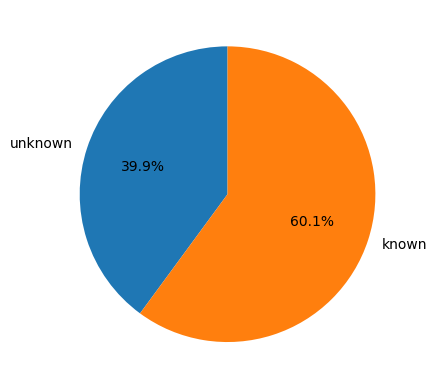

In [ ]:
all_validation_text = data_validation['question_tagged'].sum()
list_balises_validation = re.findall(regex, all_validation_text)
balises_validation = Counter(list_balises_validation)
l_balises_validation = balises_validation.keys()
unknown = [bal for bal in list_balises_validation if bal not in l_balises_train]

fig, ax = plt.subplots()
unknow_percent = round(len(unknown)/len(l_balises_validation)*100,2)
ax.pie([unknow_percent,100-unknow_percent], labels=['unknown', 'known'], startangle=90, autopct='%1.1f%%')
plt.show()

#### 7.0.3. Déterminez les 10 identifiants uniques les plus fréquents du jeu d'entrainement.

Affichez le résultat dans un diagramme à barres.


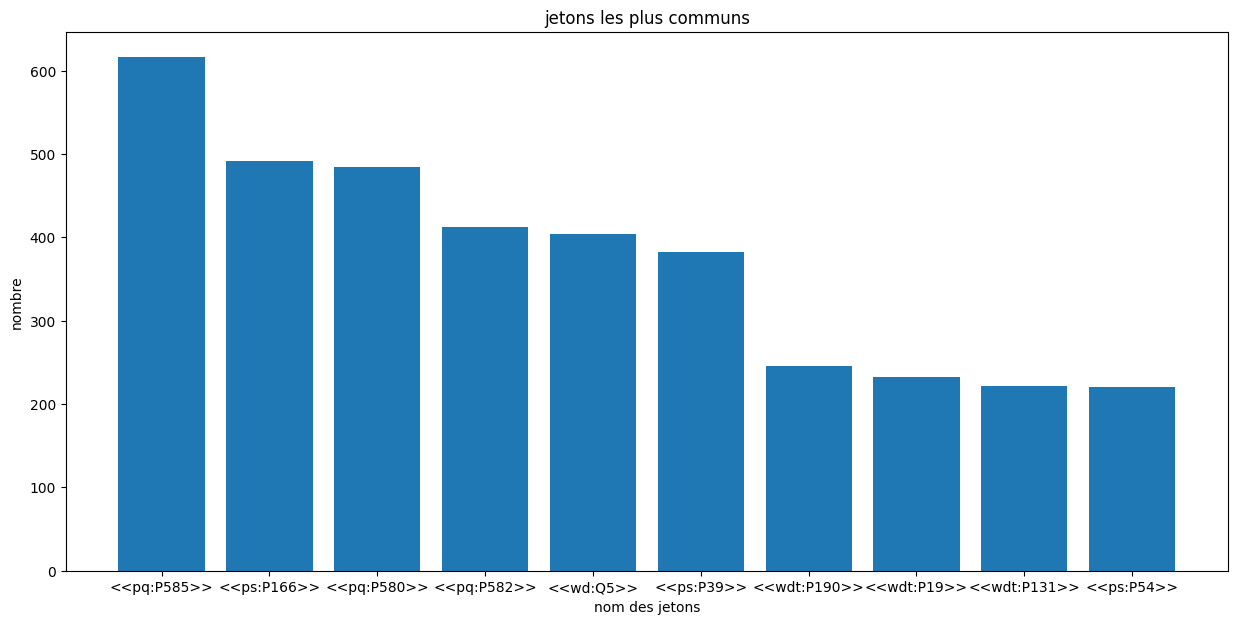

In [ ]:
most_commons = balises_train.most_common(10)
jetons = [x[0] for x in most_commons]
values = [x[1] for x in most_commons]
plt.figure(figsize=(15, 7))
plt.bar(jetons,values)
plt.title('jetons les plus communs')
plt.xlabel('nom des jetons')
plt.ylabel('nombre')
plt.show()

#### 7.0.4. Déterminez la proportion des identifiants uniques qui sont des ressources Wikidata.

Affichez le résultat dans un diagramme circulaire.

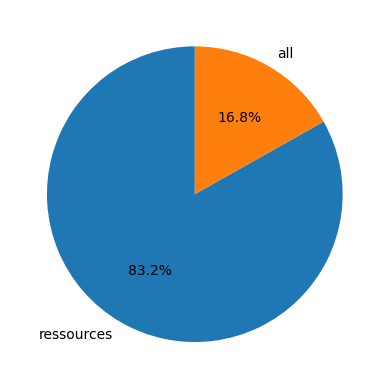

In [ ]:
ressources = [bal for bal in l_balises_train if bal.startswith('<<wd:Q')]
fig, ax = plt.subplots()
ressources_percent = round(len(set(ressources))/len(set(l_balises_train))*100,2)
ax.pie([ressources_percent,100-ressources_percent], labels=['ressources', 'all'], startangle=90, autopct='%1.1f%%')
plt.show()

>On remarque que les ressources sont prépondérantes parmis les labels

#### 7.0.5. Déterminez la fréquence de chaque entité Wikidata du jeu d'entrainement, ordonnée par fréquence décroissante et affichez une courbe fréquence - rang.

Créez un graphique de courbe fréquence-rang pour visualiser la distribution des fréquences. Sur l'axe horizontal (rang), vous aurez la position des entités triées par ordre décroissant de fréquence, et sur l'axe vertical (fréquence), vous aurez le nombre d'occurrences de chaque entité.

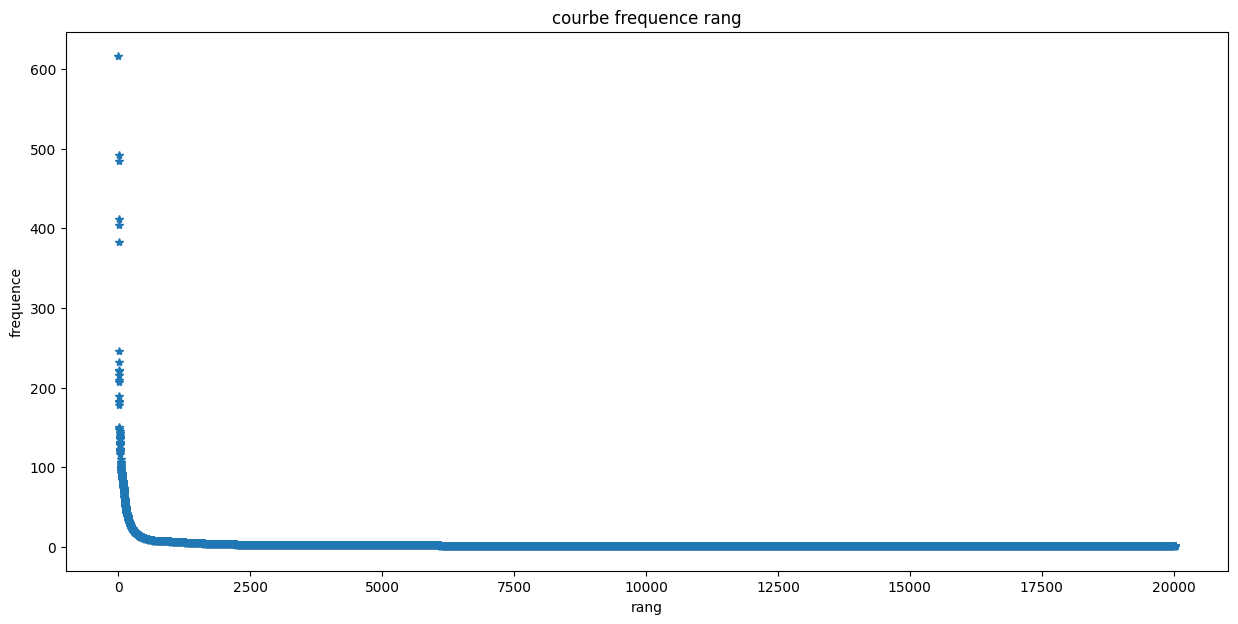

In [ ]:
most_commons = balises_train.most_common()

values = [x[1] for x in most_commons]
plt.figure(figsize=(15, 7))
plt.plot(range(len(values)), values, '*')
plt.title('courbe frequence rang')
plt.xlabel('rang')
plt.ylabel('frequence')
plt.show()

>Cela ressemble à une loi de Ziph, on se doute que le challenge sera de bien classifier les jetons les moins fréquents

### 7.1. Approche par classification de jeton (25%)

Entrainez un modèle (BERT, ROBERTA, etc.) pour classifier les jetons du __question_original__ avec le bon identifiant de Wikidata.

Votre modèle devrait utiliser le format BIO afin d'effectuer la classification.

Ainsi, si une entité se retrouve dans plusieurs jetons, vous devez indiquer qu'il s'agit du début de l'entité en rajoutant le préfixe __B-__ à la classe. Un jeton faisant partie de l'entité doit avoir le préfixe __I-__ à la classe.

Lorsqu'un jeton ne fait pas partie d'une entité, celui-ci devrait avoir la classe __O__

__Exemple:__

Jeu de validation:

|   question_id   |                  question_original                           |
|    :----:       | :----------------------------------------------:             |
|      1          | What is the {country} for {head of state} of {Justin Trudeau} |



__Étape à suivre:__

1. Vous devez segmenter la __question_original__ avec le "tokenizer" de votre choix
2. Pour chaque jeton, votre modèle doit prédire la classe associée

| __question_original__ tokenize | What | is | the | { | country | } | for | { | head | of | state | } | of | \{ | ... |
|------|------|----|-----|---|---------|---|-----|---|------|----|-------|---|---|---| --- |
| Résultat du modèle    | O    | O  | O   | B-wd:Q6256 | I-wd:Q6256 | I-wd:Q6256 | O | B-wdt:P35 | I-wdt:P35 | I-wdt:P35 | I-wdt:P35 | I-wdt:P35 | O | B-wd:Q3099714 | ... |



#### 7.1.1. Classification de jetons (20%)


Creation de la chaine de traitement des jetons


In [ ]:

def remove_duplicate_brackets(text):
    # Regex to find nested duplicate brackets
    # This regex matches '{{', '}}', '{ {' and '} }'
    regex = r"(\{\{|\}\}|\{\s\{|\}\s\})"

    def replace_brackets(match):
        bracket = match.group(0)
        # Remove the first bracket for opening and the last bracket for closing
        if bracket in ["{{", "{ {"]:
            return "{"
        else:
            return "}"

    # Replace the found brackets using the defined function
    return re.sub(regex, replace_brackets, text)

def preprocess(df : pd.DataFrame) :
    #return the data to the following shape : array[phrases, word of phrases], list[phrases, label of word phrases]
    original_tokens = []
    labels = []
    #Assignation des labels à chaque token de la phrase raw afin en debruitant le dataset

    for i, row in df.iterrows():
        question = row['question_original']
        tagged = row['question_tagged']
        raw = row['question_raw']

        #pre traitement
        question = question.replace("<","{").replace(">","}")
        question = remove_duplicate_brackets(question)
        question = question.replace("{"," { ").replace("}"," } ")
        question = re.sub(r'\{\s*\}','',question)
        # Tokenize the question
        tokens = raw.split()
        tokenized_question = question.split()
        O_tokens = nltk.word_tokenize(re.sub(r'<<[^>]*>>', '', tagged))

        # Initialize labels for each token
        token_labels = []
        tag_ind = 0
        tag_list = re.findall(r'<<([^>]*)>>', tagged)
        sequence = False
        question_ind = 0
        for ind, tok in enumerate(tokens) :
            if sequence == False and tokenized_question[question_ind] != "{" :
                if O_tokens[0] == tok :
                    token_labels.append('O')
                    O_tokens.pop(0)
                    if tokenized_question[question_ind].lower().startswith(tok.lower()) or tokenized_question[question_ind].startswith(tok):
                        tokenized_question[question_ind] = tokenized_question[question_ind][len(tok):]
                        if tokenized_question[question_ind] == "" :
                            question_ind += 1
                    else :
                        raise Exception(f"{i} error 0 in tokenization at token {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")
                else :
                    raise Exception(f"{i} error 1 in tokenization at token  {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")
            elif sequence == False and tokenized_question[question_ind] == "{" :
                question_ind += 1
                sequence = True
                if tokenized_question[question_ind].lower().startswith(tok.lower())or tokenized_question[question_ind].startswith(tok):
                    token_labels.append('B-'+tag_list[tag_ind])
                    tokenized_question[question_ind] = tokenized_question[question_ind][len(tok):]
                    if tokenized_question[question_ind] == "" :
                        question_ind += 1
                else :
                    print(tokenized_question[question_ind], tok, question_ind , tokenized_question)
                    raise Exception(f"{i} error 2 in tokenization at token {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")
            elif sequence == True and tokenized_question[question_ind] != "}" :
                if tokenized_question[question_ind].lower().startswith(tok.lower()) or tokenized_question[question_ind].startswith(tok):
                    token_labels.append('I-'+tag_list[tag_ind])
                    tokenized_question[question_ind] = tokenized_question[question_ind][len(tok):]
                    if tokenized_question[question_ind] == "" :
                        question_ind += 1
                else :
                    print(tokenized_question[question_ind], tok, question_ind , tokenized_question)
                    raise Exception(f"{i} error 3 in tokenization at token {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")
            elif sequence == True and tokenized_question[question_ind] == "}" :
                sequence = False
                question_ind += 1
                tag_ind += 1
                if tokenized_question[question_ind] != "{" :
                    if O_tokens[0] == tok :
                        token_labels.append('O')
                        O_tokens.pop(0)
                        question_ind += 1
                    else :
                        raise Exception(f"{i} error 4 in tokenization at token {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")
                else :
                    question_ind += 1
                    sequence = True
                    if tokenized_question[question_ind].lower().startswith(tok.lower()) or tokenized_question[question_ind].startswith(tok):
                        token_labels.append('B-'+tag_list[tag_ind])
                        tokenized_question[question_ind] = tokenized_question[question_ind][len(tok):]
                        if tokenized_question[question_ind] == "" :
                            question_ind += 1
                    else :
                        raise Exception(f"{i} error 5 in tokenization at token {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")


        original_tokens.append(tokens)
        labels.append(token_labels)



    return original_tokens, labels



In [ ]:
#return the data to the following shape : array[phrases, word of phrases], list[phrases, label of word phrases]
def preprocess_test(df : pd.DataFrame) :
    original_tokens = []
    for _, row in df.iterrows():
        question = row['question_raw']
        tokens = question.split()
        original_tokens.append(tokens)
    return original_tokens

#### Créations du dataset d'entrainement

In [ ]:
tokens_train, labels_train = preprocess(data_train)

In [ ]:
#check length of tokens and labels
assert len(tokens_train) == len(labels_train)
for i in range(len(tokens_train)):
    assert len(tokens_train[i]) == len(labels_train[i])

#### Création des mapping

In [ ]:
# dumb mapping
label_map = {}
unique_labels = set([label for labels in labels_train for label in labels])
# For each label...
for (i, label) in enumerate(unique_labels):
    # Map it to its integer.
    label_map[label] = i

In [ ]:
print("Example sentence:")
print ("    Tokens:", tokens_train[4136])
print ("    Labels:", labels_train[4136])

print ('\nSentence Tokens and Labels:')
for i in zip(tokens_train[4136], labels_train[4136]):
  print (i)

Example sentence:
    Tokens: ['what', 'is', 'birthplace', 'of', 'robert', 'rayford', ',', 'that', 'has', 'abbreviation', 'is', 'ארה', '"', 'ב', '?']
    Labels: ['O', 'O', 'B-wdt:P19', 'O', 'B-wd:Q288055', 'I-wd:Q288055', 'O', 'O', 'O', 'B-wdt:P1813', 'O', 'B-\'ארה"ב\'', 'I-\'ארה"ב\'', 'I-\'ארה"ב\'', 'O']

Sentence Tokens and Labels:
('what', 'O')
('is', 'O')
('birthplace', 'B-wdt:P19')
('of', 'O')
('robert', 'B-wd:Q288055')
('rayford', 'I-wd:Q288055')
(',', 'O')
('that', 'O')
('has', 'O')
('abbreviation', 'B-wdt:P1813')
('is', 'O')
('ארה', 'B-\'ארה"ב\'')
('"', 'I-\'ארה"ב\'')
('ב', 'I-\'ארה"ב\'')
('?', 'O')


In [ ]:
!pip install transformers

#### calcul de la longeur maximale d'une sequence

In [ ]:
from transformers import BertTokenizerFast
import numpy as np


tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# Record the length of each sequence.
lengths = []

print('Measuring sentence lengths...')

for sen in tokens_train:

    sen = ' '.join(sen)
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    lengths.append(len(encoded_sent))
for i,row in data_validation.iterrows():
    sen = row['question_raw']
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    lengths.append(len(encoded_sent))

for i, row in data_test.iterrows():
    sen = row['question_raw']
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    lengths.append(len(encoded_sent))
print('    DONE.')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Measuring sentence lengths...
    DONE.


In [ ]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))

   Min length: 7 tokens
   Max length: 115 tokens
Median length: 15 tokens


<ipython-input-21-82c5ce17149b>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lengths, kde=False, rug=False)


Text(0, 0.5, '# of Sentences')

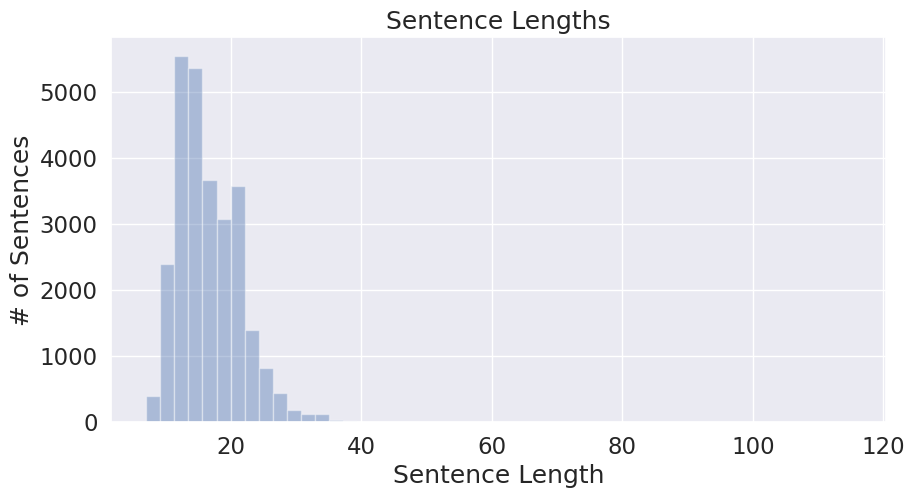

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution
sns.distplot(lengths, kde=False, rug=False)

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')

on remarque que les phrases sont majoritairement courtes mais pas toujours. afin de traiter cela nous fixons la longueure maximale à 120

In [ ]:
def tokenize_from_model(tokenizer, sentences):
    input_ids = []
    attention_masks = []
    sent_word_ids = []
    for sent in sentences:

        encoded_dict = tokenizer.encode_plus(
                            sent,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation = True,
                            max_length = 120,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            return_offsets_mapping=True,
                            is_split_into_words=True
                            )
        word_ids = encoded_dict.word_ids()
        sent_word_ids.append(word_ids)
        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'][0])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'][0])
    return input_ids, attention_masks, sent_word_ids

input_ids_train, attention_masks_train, word_ids_train = tokenize_from_model(tokenizer, tokens_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', tokens_train[4136])
print('Token IDs:', input_ids_train[4136])
print('Masks:', attention_masks_train[4136])
print('word_ids:', word_ids_train[4136])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  ['what', 'is', 'birthplace', 'of', 'robert', 'rayford', ',', 'that', 'has', 'abbreviation', 'is', 'ארה', '"', 'ב', '?']
Token IDs: tensor([  101,  2054,  2003, 14508,  1997,  2728,  4097,  3877,  1010,  2008,
         2038, 22498,  2003,  1241, 29811, 29128,  1000,  1242,  1029,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,


In [ ]:
def get_new_labels(tokenizer, input_ids, word_ids_list, labels, label_map):
    # New labels for all of the input sentences.
    new_labels = []
    # The special label ID we'll give to "extra" tokens.
    null_label_id = -100

    for  token_ids, word_ids, orig_labels in zip( input_ids, word_ids_list, labels):

        # Create a new list to hold the adjusted labels for this sentence.
        padded_labels = []

        for n,(token_id, word_id) in enumerate(zip(token_ids, word_ids)):

            if token_id in [tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.sep_token_id] or (word_id is None):
                padded_labels.append(null_label_id)
            else:
                # Assign the label of the original word to the token
                label_str = orig_labels[word_id]
                #si le mot a été split a cause de caracteres speciaux, alors c'est la suite du label initial donc on met
                if n >= 0 and word_ids[n-1] == word_id : #c'est le meme mot mais splitté par la tokenization
                    label_id = null_label_id
                else :
                    label_id = label_map.get(label_str, null_label_id)
                padded_labels.append(label_id)
        new_labels.append(padded_labels)

    return new_labels

In [ ]:
new_train_labels = get_new_labels(tokenizer, input_ids_train, word_ids_train, labels_train, label_map)

In [ ]:
print('\nSentence:    ', tokens_train[4136])
print('\nLabels:      ', labels_train[4136])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(tokens_train[4136])))
print('\nWord ID List ', word_ids_train[4136])
print('\nToken IDs:   ', input_ids_train[4136])
print('\nNew Labels:  ', new_train_labels[4136])
print('\nNew Labels transformed:  ', [list(label_map.keys())[list(label_map.values()).index(label)] for label in new_train_labels[4136] if label != -100])
print('\nMask:        ', attention_masks_train[4136])


Sentence:     ['what', 'is', 'birthplace', 'of', 'robert', 'rayford', ',', 'that', 'has', 'abbreviation', 'is', 'ארה', '"', 'ב', '?']

Labels:       ['O', 'O', 'B-wdt:P19', 'O', 'B-wd:Q288055', 'I-wd:Q288055', 'O', 'O', 'O', 'B-wdt:P1813', 'O', 'B-\'ארה"ב\'', 'I-\'ארה"ב\'', 'I-\'ארה"ב\'', 'O']

BERT Tokens:  ['what', 'is', 'birthplace', 'of', 'robert', 'ray', '##ford', ',', 'that', 'has', 'abbreviation', 'is', 'א', '##ר', '##ה', '"', 'ב', '?']

Word ID List  [None, 0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11, 11, 11, 12, 13, 14, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 

In [ ]:
tokens_validation, labels_validation = preprocess(data_validation)
input_ids_val, attention_masks_val, word_ids_val = tokenize_from_model(tokenizer, tokens_validation)
new_val_labels = get_new_labels(tokenizer, input_ids_val, word_ids_val, labels_validation, label_map)

In [ ]:
#check all labels from labels_validation that are not in label_map
unknown_labels = []
nb_to_classifie = 0
for label in labels_validation :
    nb_to_classifie += len(label)
    for l in label :
        if l not in label_map.keys() :
            unknown_labels.append(l)
unknown_labels_unique = list(set(unknown_labels))
print(len(unknown_labels_unique))
print(len(labels_validation))

print(len(unknown_labels)/nb_to_classifie)

2990
2183
0.1645467322557976


>on remarque qu'une proportion non négligeable des labels est inconnue

#### Création des Tenseurs et datasets d'entrainement

In [ ]:
#
pt_input_ids = torch.stack(input_ids_train, dim=0)
pt_input_ids_val = torch.stack(input_ids_val, dim=0)

pt_attention_masks = torch.stack(attention_masks_train, dim=0)
pt_attention_masks_val = torch.stack(attention_masks_val,dim=0)

pt_labels = torch.tensor(new_train_labels, dtype=torch.long)
pt_labels_val = torch.tensor(new_val_labels, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, random_split


# Combine the training inputs into a TensorDataset.
dataset_train = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
dataset_val_tr = TensorDataset(pt_input_ids_val,pt_attention_masks_val, pt_labels_val)
# Create a 90-10 train-validation split.

print('{:>5,} training samples'.format(len(dataset_train)))
print('{:>5,} validation samples'.format(len(dataset_val_tr)))

19,603 training samples
2,183 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16


train_dataloader = DataLoader(
            dataset_train,  # The training samples.
            sampler = RandomSampler(dataset_train), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader_tr = DataLoader(
            dataset_val_tr,
            batch_size = batch_size# Evaluate with this batch size.
        )

#### Chargement du modèle BERT préentrainé

In [ ]:
from transformers import BertForTokenClassification, AdamW, BertConfig

# Load BertForTokenClassification
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(label_map) + 1, # The number of output labels--18 for our NER dataset
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

#### Définition des parametres de l'entrainement

In [ ]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import time
import numpy as np
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
device = torch.device("cuda")

#### Création des fonctions d'évalution du f1 score et accuracy

In [ ]:
from sklearn.metrics import f1_score
def get_label_list_from_predict(predict_labels, word_ids_list, label_map : dict):
    # New labels for all of the input sentences.
    predict_labels_formated = []

    for  word_ids, orig_labels in zip( word_ids_list, predict_labels):

        # Create a new list to hold the adjusted labels for this sentence.
        padded_labels = []
        # For each token in the sentence...
        for n,(word_id, label) in enumerate(zip(word_ids, orig_labels)):
            if word_id != None :
                label_str = list(label_map.keys())[list(label_map.values()).index(label)]
                if n>=0 and word_ids[n-1] == word_id:
                    continue
                else :
                    padded_labels.append(label_str)
            else :
                continue

        predict_labels_formated.append(padded_labels)

    return predict_labels_formated

def compute_metrics(labels : np.array, preds : np.array, count_O=False):

    assert len(preds) == len(labels)
    for pred, label in zip(preds, labels):
        assert len(pred) == len(label)
    #flatten labels and preds with numpy methode
    labels = np.concatenate(labels)
    preds = np.concatenate(preds)
    #remove all O labels
    mask_O = labels != 'O'

    if count_O :
        accuracy = (preds == labels).mean()
        f1 = f1_score(labels, preds, average="macro")
    else :
        accuracy = (preds[mask_O] == labels[mask_O]).mean()
        f1 = f1_score(labels[mask_O], preds[mask_O], average="macro")
    return accuracy, f1

def get_evaluation_metrics(model, val_dataloader,word_ids_list, label_map : dict, labels_true) :
    model.eval()
    total_loss = 0
    predict_labels = []
    with torch.no_grad() :
        for step, batch in enumerate(val_dataloader) :
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
            logits = result.logits
            logits = logits.detach().cpu().numpy()
            predict_labels.append(np.argmax(logits, axis=2))
            loss = result.loss
            total_loss += loss.item()
    predict_labels = np.concatenate(predict_labels)
    formated_predict_labels = get_label_list_from_predict(predict_labels, word_ids_list, label_map)
    accuracy, f1 = compute_metrics(labels_true, formated_predict_labels)
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss, accuracy, f1


#### Boucle D'entrainement

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
loss_values_val = []
accuracy_values_val = []
f1_score_values_val = []

for epoch_i in range(0, epochs):



    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        result = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = result.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()


    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    avg_loss = get_evaluation_metrics(model, validation_dataloader_tr, word_ids_val, label_map, labels_validation)
    loss_values_val.append(avg_loss[0])
    accuracy_values_val.append(avg_loss[1])
    f1_score_values_val.append(avg_loss[2])


    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Validation loss: {0:.2f}".format(avg_loss[0]))
    print(" Validation Accuracy: {0:.2f}".format(avg_loss[1]))
    print(" Validation F1 score: {0:.2f}".format(avg_loss[2]))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of  1,226.    Elapsed: 0:00:08.
  Batch    80  of  1,226.    Elapsed: 0:00:14.
  Batch   120  of  1,226.    Elapsed: 0:00:20.
  Batch   160  of  1,226.    Elapsed: 0:00:25.
  Batch   200  of  1,226.    Elapsed: 0:00:31.
  Batch   240  of  1,226.    Elapsed: 0:00:36.
  Batch   280  of  1,226.    Elapsed: 0:00:42.
  Batch   320  of  1,226.    Elapsed: 0:00:48.
  Batch   360  of  1,226.    Elapsed: 0:00:54.
  Batch   400  of  1,226.    Elapsed: 0:01:00.
  Batch   440  of  1,226.    Elapsed: 0:01:05.
  Batch   480  of  1,226.    Elapsed: 0:01:11.
  Batch   520  of  1,226.    Elapsed: 0:01:16.
  Batch   560  of  1,226.    Elapsed: 0:01:22.
  Batch   600  of  1,226.    Elapsed: 0:01:28.
  Batch   640  of  1,226.    Elapsed: 0:01:33.
  Batch   680  of  1,226.    Elapsed: 0:01:39.
  Batch   720  of  1,226.    Elapsed: 0:01:45.
  Batch   760  of  1,226.    Elapsed: 0:01:50.
  Batch   800  of  1,226.    Elapsed: 0:01:56.
  Batch   840  o

In [ ]:
torch.save(model, root+'my_model_batch_16_10_epoch.pth')

### Affichage des performances

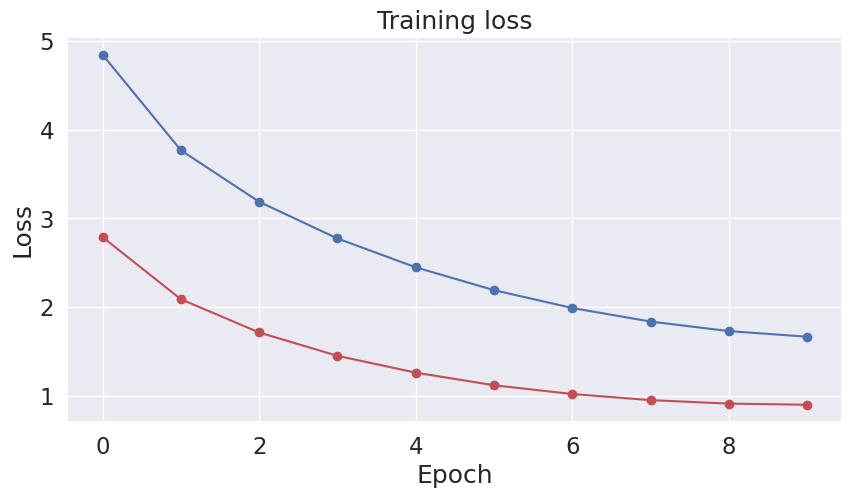

In [ ]:
#plot loss
import matplotlib.pyplot as plt

plt.plot(loss_values, 'b-o')
plt.plot(loss_values_val, 'r-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

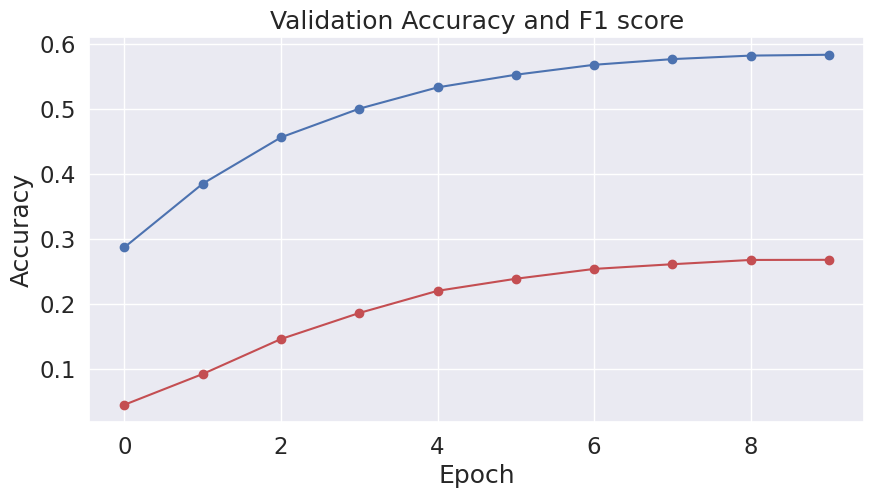

In [ ]:
#plot accuracy and f1 evolution
plt.plot(accuracy_values_val, 'b-o')
plt.plot(f1_score_values_val, 'r-o')
plt.title("Validation Accuracy and F1 score")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#### 7.1.2. Évaluation (5%)

Évaluez votre modèle sur le jeu de validation en utilisant la métrique «  Macro F1-Score Moyenne ».


Implémentez la fonction permettant de calculer la métrique Macro F1-Score Moyenne

In [ ]:
avg_loss = get_evaluation_metrics(model, validation_dataloader_tr, word_ids_val, label_map, labels_validation)
loss_values_val.append(avg_loss[0])
accuracy_values_val.append(avg_loss[1])
f1_score_values_val.append(avg_loss[2])

#print score f1 et accuracy en % sur le jeu de validation
print(" Validation Accuracy: {0:.2f}".format(avg_loss[1]))
print(" Validation F1 score: {0:.2f}".format(avg_loss[2]))

 Validation Accuracy: 0.58
 Validation F1 score: 0.27


> le F1 obtenu n'est pas mauvais et est au dessus de la Baseline donnée sur le moodle \(50% et 20%)